### This notebook is the first step to check whether geopandas can be used entirely for vector related raster clipping using pygeotools or not

In [1]:
from pygeotools.lib import  geolib, malib, iolib, warplib
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline
import ogr, gdal
import shapely

In [2]:
import rasterio, affine

In [50]:
import numpy as np

In [3]:
iolib.cpu_count()

20

In [4]:
shp_fn='data/Sikkim_kanchenjunga.shp'
raster_fn='data/Rate_maps_Coregister-tile-0-last_inverted_ref.tif'
shp_gdf=gpd.read_file(shp_fn)
dh_ref_ma=iolib.fn_getma(raster_fn)

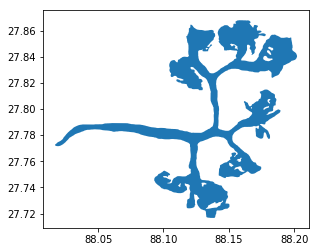

In [5]:
shp_gdf.plot()

In [17]:
shp_gdf

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,orig_ogc_f,geometry
0,RGI60-15.02846,G088140E27800N,20001108,-9999999,88.139674,27.799822,15,2,58.261,4601,...,21413,0,0,0,0,9,9,None,85334,"POLYGON ((88.16059143000007 27.86790288700007,..."


In [22]:
geom_gdf=shp_gdf.geometry

In [20]:
linelyr = ogr.CreateGeometryFromWkt(geom_gdf.wkt)

AttributeError: 'GeoSeries' object has no attribute 'wkt'

In [9]:
a=geolib.shp2geom(shp_fn)

In [23]:
a[0].Buffer(10)

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7fa7789ca300> >

##### The geopandas geometry is an object, while the one expected in pygeotools is an ogr geometry

In [21]:
a.Buffer(10)

AttributeError: 'list' object has no attribute 'Buffer'

In [14]:
ring = ogr.Geometry(ogr.wkbLinearRing)
ring.AddPoint(1179091.1646903288, 712782.8838459781)
ring.AddPoint(1161053.0218226474, 667456.2684348812)
ring.AddPoint(1214704.933941905, 641092.8288590391)
ring.AddPoint(1228580.428455506, 682719.3123998424)
ring.AddPoint(1218405.0658121984, 721108.1805541387)
ring.AddPoint(1179091.1646903288, 712782.8838459781)

In [15]:
ring

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7fa7788ee060> >

In [16]:
hurri=ogr.Geometry(ogr.wkbPolygon)

In [17]:
hurri.AddGeometry(shp_gdf.geometry)

TypeError: in method 'Geometry_AddGeometry', argument 2 of type 'OGRGeometryShadow *'

### After three hours of skimming, it looks like staying in ogr mode is better for such operations....
Proposed strategy
Read the shapefile
input only the dh on stable surfaces
create a buffer geometry of given units
geom2mask and extract the dh as masked array
normal transform the masked array
compute variogram
do sequential gaussian simulations
get per pixel mean and std as errors


### Create a git repo tomorrow ----- Important

##### We will create a new projected shapefile, so that we are able to do the manipulations in metre units

In [11]:
shp_ds=ogr.Open(shp_fn,0)
shp_lyr=shp_ds.GetLayer()
reproj_ds=geolib.lyr_proj(shp_lyr,t_srs=geolib.hma_aea_srs)

In [12]:
reproj_ds

<osgeo.ogr.DataSource; proxy of <Swig Object of type 'OGRDataSourceShadow *' at 0x7f4532c79e10> >

In [13]:
reproj_lyr=reproj_ds.GetLayer()
reproj_feat=reproj_lyr.GetNextFeature()
reproj_geom=geom = reproj_feat.GetGeometryRef()

In [14]:
reproj_geom

<osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x7f4532c799f0> >

In [ ]:
reproj_geom.Buffer()

In [23]:
from pygeostatistics import normal_score_transform


### compare rasterio outputs with pygeotools to check the degree of reverse engineetin required
##### In particular, check the submodules :- 
###### filtlib should work except for the slope filter
###### iolib is obviously different
###### timelib should work
###### warplib will need modifications
###### geolib will neeed major modifications
### As on 26th September, 2018

In [6]:
rasterio_dataset= rasterio.open(raster_fn)
pygeotools_dataset=iolib.fn_getds(raster_fn)

In [7]:
gt_p=pygeotools_dataset.GetGeoTransform()
gt_r=rasterio_dataset.transform

In [8]:
rasterio_dataset.transform

Affine(10.0, 0.0, 551333.3925950001,
       0.0, -10.0, 3115850.7827000003)

In [9]:
gt_p

(551333.3925950001, 10.0, 0.0, 3115850.7827000003, 0.0, -10.0)

In [10]:
gt_r

Affine(10.0, 0.0, 551333.3925950001,
       0.0, -10.0, 3115850.7827000003)

##### To convert back and forth from the gdal tuple to affine transform
https://www.perrygeo.com/python-affine-transforms.html

In [11]:
gt_rp = gt_r.to_gdal()

In [12]:
gt_rp

(551333.3925950001, 10.0, 0.0, 3115850.7827000003, 0.0, -10.0)

In [13]:
gt_pr=affine.Affine.from_gdal(*gt_p)

In [14]:
gt_pr

Affine(10.0, 0.0, 551333.3925950001,
       0.0, -10.0, 3115850.7827000003)

#### Reading data from rasterio as arrays or masked arrays

In [15]:
array_rasterio=rasterio_dataset.read(1)

In [16]:
array_rasterio

array([[3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       ...,
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38],
       [3.4028235e+38, 3.4028235e+38, 3.4028235e+38, ..., 3.4028235e+38,
        3.4028235e+38, 3.4028235e+38]], dtype=float32)

In [17]:
array_rasterio_masked=rasterio_dataset.read(1, masked=True)

In [18]:
pygeotools_raster_masked=iolib.ds_getma(pygeotools_dataset)

In [19]:
pygeotools_raster_masked.shape

(8653, 16353)

In [20]:
array_rasterio_masked.shape

(8653, 16353)

In [21]:
array_rasterio_masked.mean()

-0.07533278900058527

In [22]:
pygeotools_raster_masked.mean()

-0.07533278900058527

In [23]:
pygeotools_raster_masked.min()

-195.45059

In [24]:
array_rasterio_masked.min()

-195.45059

###### Clipping Possibility with Fiona

In [37]:
import fiona

In [38]:
with fiona.open(shp_fn, "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]


In [39]:
geoms

[{'type': 'Polygon',
  'coordinates': [[(88.16059143000007, 27.86790288700007),
    (88.16112835200005, 27.86785060300008),
    (88.16166578300005, 27.867846077000024),
    (88.16225695600008, 27.867841096000063),
    (88.16279438700008, 27.86783656600005),
    (88.16338505000004, 27.867783819000067),
    (88.16366583600006, 27.867698002000054),
    (88.16386425400003, 27.867774375000067),
    (88.16439027800004, 27.867821826000068),
    (88.16491574700007, 27.86781738800005),
    (88.16543955000003, 27.867657290000068),
    (88.16596279700008, 27.867445303000068),
    (88.16630866300005, 27.867027251000025),
    (88.16665508300008, 27.866661085000032),
    (88.16665008100006, 27.86619410900005),
    (88.16641209800008, 27.865780994000033),
    (88.16588497300006, 27.865629779000074),
    (88.16584990100006, 27.865619717000072),
    (88.16599135700005, 27.86523027100003),
    (88.16630971600006, 27.864845460000026),
    (88.16662807300008, 27.864460648000033),
    (88.16662756100004, 2

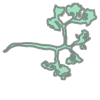

In [41]:
shp_gdf.geometry[

In [44]:
geoms.dtype

AttributeError: 'list' object has no attribute 'dtype'

###### Geopamdas Experiment

#### what David does is rasterizes the shapefile in form of arrays, this same can be done with geopandas library using the example given in the xarray forum
https://github.com/pydata/xarray/issues/501

In [26]:
shp_gdf.crs

{'init': 'epsg:4326'}

In [27]:
rasterio_dataset.crs

CRS({'init': 'epsg:32645'})

In [28]:
shp_gdf_projected_raster=shp_gdf.copy()
shp_gdf_projected_raster['geometry']=shp_gdf_projected_raster['geometry'].to_crs(rasterio_dataset.crs)

In [29]:
shp_gdf_projected_raster.crs

{'init': 'epsg:4326'}

In [30]:
shp_gdf_projected_raster.geometry

0    POLYGON ((614255.561575591 3083110.395163486, ...
Name: geometry, dtype: object

In [31]:
shp_gdf.geometry

0    POLYGON ((88.16059143000007 27.86790288700007,...
Name: geometry, dtype: object

In [32]:
shp_gdf_projected_raster=shp_gdf_projected_raster.to_crs(rasterio_dataset.crs)

In [33]:
shp_gdf_projected_raster.crs

CRS({'init': 'epsg:32645'})

In [34]:
shp_gdf_projected_raster.geometry

0    POLYGON ((inf inf, inf inf, inf inf, inf inf, ...
Name: geometry, dtype: object

In [35]:
shp_gdf_proj=shp_gdf.copy

In [36]:
shp_gdf=shp_gdf.to_crs(rasterio_dataset.crs)

In [37]:
shp_gdf.geometry

0    POLYGON ((614255.561575591 3083110.395163486, ...
Name: geometry, dtype: object

In [38]:
from rasterio import features

In [45]:
shape_array=features.rasterize(shp_gdf.geometry, out_shape=array_rasterio_masked.shape,fill=-9999,transform=rasterio_dataset.transform,dtype=float)

In [46]:
shape_array.shape

(8653, 16353)

In [47]:
shape_array

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

In [51]:
shape_masked=np.ma.masked_where(shape_array==-9999, shape_array)

In [52]:
shape_masked

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [56]:
shape_masked.mean()

1.0

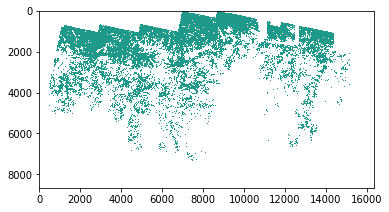

In [57]:
plt.imshow(array_rasterio_masked)

In [59]:
glacier_cutoff=np.ma.array(array_rasterio_masked, mask=shape_masked.mask)

In [60]:
glacier_cutoff.shape

(8653, 16353)

In [61]:
glacier_cutoff.max()

masked

In [62]:
glacier_cutoff.min()

masked

###### To Do's 
Make a buffer
Extract data
pack it in xyz format 
try to read it to pygeostatistics
